<a href="https://colab.research.google.com/github/Kobrun4ik/Cheminformatics/blob/main/Kobrin_Cheminformatics_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy.linalg import norm
from math import pi, cos, sin
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from matplotlib import path as mpl_path
import time

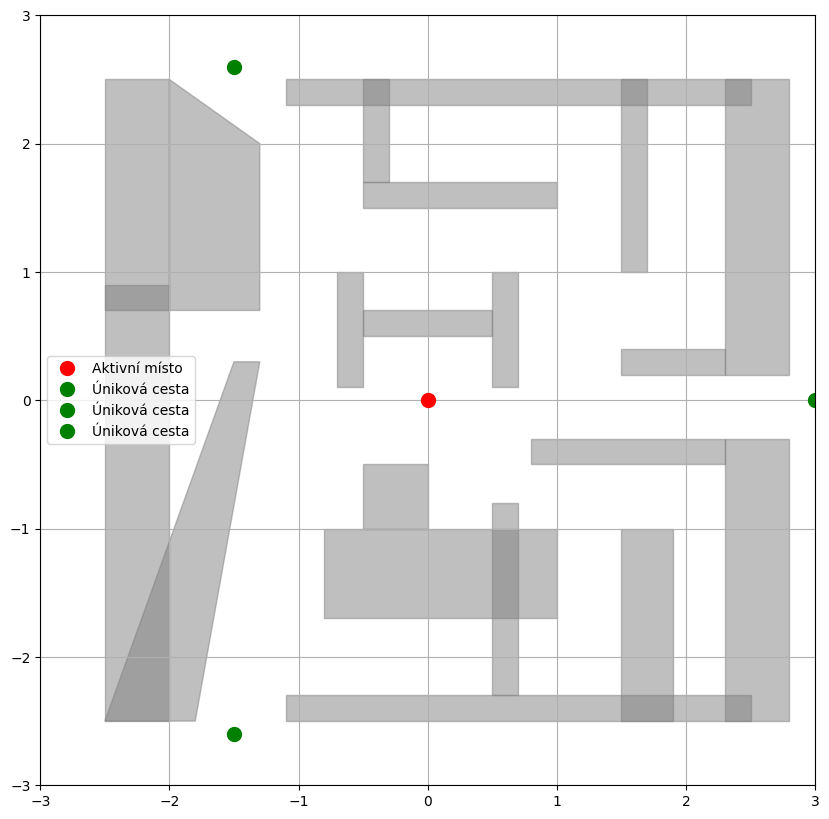

In [2]:
# Pomocné funkce pro kontrolu kolizí

def isCollisionFreeVertex(obstacles, xy):
    """
    Kontroluje, zda daný bod (xy) není v kolizi s překážkami.
    """
    for obstacle in obstacles:
        hull = mpl_path.Path(obstacle)
        if hull.contains_points([xy]):
            return False
    return True

def isCollisionFreeEdge(obstacles, closest_vert, xy):
    """
    Kontroluje, zda hrana mezi dvěma body není v kolizi s překážkami.
    """
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = max(int(l / map_resolution), 20)
    t = np.linspace(0, 1, M)
    for i in range(1, M - 1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        if not isCollisionFreeVertex(obstacles, p):
            return False
    return True

# Funkce pro vykreslení mapy s překážkami

def draw_map(obstacles, active_site=None, escape_routes=None, paths=None, rrt_nodes=None):
    """
    Vykreslí mapu s překážkami, aktivním místem, únikovými cestami, nalezenými cestami a propojenými uzly RRT.
    """
    world_bounds_x = [-3, 3]
    world_bounds_y = [-3, 3]
    plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for obstacle in obstacles:
        ax.add_patch(Polygon(obstacle, color='gray', alpha=0.5))
    if active_site is not None:
        plt.plot(active_site[0], active_site[1], 'ro', markersize=10, label='Aktivní místo')
    if escape_routes is not None:
        for route in escape_routes:
            plt.plot(route[0], route[1], 'go', markersize=10, label='Úniková cesta')
    # if rrt_nodes is not None:
    #     for node in rrt_nodes:
    #         if node.iPrev is not None:
    #             prev_node = rrt_nodes[node.iPrev]
    #             plt.plot([node.p[0], prev_node.p[0]], [node.p[1], prev_node.p[1]], 'k-', alpha=0.3)
    #         plt.plot(node.p[0], node.p[1], 'ko', markersize=3, alpha=0.5)
    if paths is not None:
        for path in paths:
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, label='Nalezená cesta')
    plt.legend()
    plt.show()

# Generování labyrintu

def generate_circular_labyrinth(center, radius, num_tunnels):
    """
    Generuje překážky a únikové cesty v kruhovém labyrintu.
    """
    obstacles = [
        # Left vertical wall with exit at the top
        np.array([[-2.5, -2.5], [-2, -2.5], [-2, 0.9], [-2.5, 0.9]]),
        np.array([[-2.5, 0.7], [-2, 0.7], [-2, 2.5], [-2.5, 2.5]]),

        np.array([[-2.5, -2.5], [-1.8, -2.5], [-1.3, 0.3], [-1.5, 0.3]]),
        np.array([[-2, 0.7], [-1.3, 0.7], [-1.3, 2], [-2, 2.5]]),

        # Right vertical wall with exit at the middle
        np.array([[2.3, -2.5], [2.8, -2.5], [2.8, -0.3], [2.3, -0.3]]),
        np.array([[2.3, 0.2], [2.8, 0.2], [2.8, 2.5], [2.3, 2.5]]),

        # Bottom horizontal wall with exit on the right
        np.array([[-1.1, -2.5], [2.5, -2.5], [2.5, -2.3], [-1.1, -2.3]]),
        np.array([[-1.1, 2.5], [2.5, 2.5], [2.5, 2.3], [-1.1, 2.3]]),

        # Internal walls to create the maze structure

        np.array([[0.5, 1], [0.7, 1], [0.7, 0.1], [0.5, 0.1]]),
        np.array([[-0.5, 1], [-0.7, 1], [-0.7, 0.1], [-0.5, 0.1]]),
        np.array([[-0.5, -1], [0, -1], [0., -0.5], [-0.5, -0.5]]),
        np.array([[1.5, 1], [1.7, 1], [1.7, 2.5], [1.5, 2.5]]),
        np.array([[1.5, -1], [1.9, -1], [1.9, -2.5], [1.5, -2.5]]),

        np.array([[0.5, -2.3], [0.7, -2.3], [0.7, -0.8], [0.5, -0.8]]),
        np.array([[2.3, -0.5], [0.8, -0.5], [0.8, -0.3], [2.3, -0.3]]),
        np.array([[-0.5, 0.5], [0.5, 0.5], [0.5, 0.7], [-0.5, 0.7]]),
        np.array([[1.5, 0.2], [2.3, 0.2], [2.3, 0.4], [1.5, 0.4]]),
        np.array([[-0.5, 1.5], [1.0, 1.5], [1.0, 1.7], [-0.5, 1.7]]),
        np.array([[-0.8, -1], [1.0, -1], [1.0, -1.7], [-0.8, -1.7]]),
        np.array([[-0.5, 1.7], [-0.3, 1.7], [-0.3, 2.5], [-0.5, 2.5]])
    ]

    angles = np.linspace(0, 2 * pi, num_tunnels, endpoint=False)
    escape_routes = [
        np.array([center[0] + (radius + 0.5) * cos(angle), center[1] + (radius + 0.5) * sin(angle)])
        for angle in angles
    ]
    return obstacles, escape_routes

# Definice aktivního místa a labyrintu
center = np.array([0, 0])
radius = 2.5
num_tunnels = 3
obstacles, escape_routes = generate_circular_labyrinth(center, radius, num_tunnels)
active_site = center

# Vykreslení labyrintu
draw_map(obstacles, active_site, escape_routes)

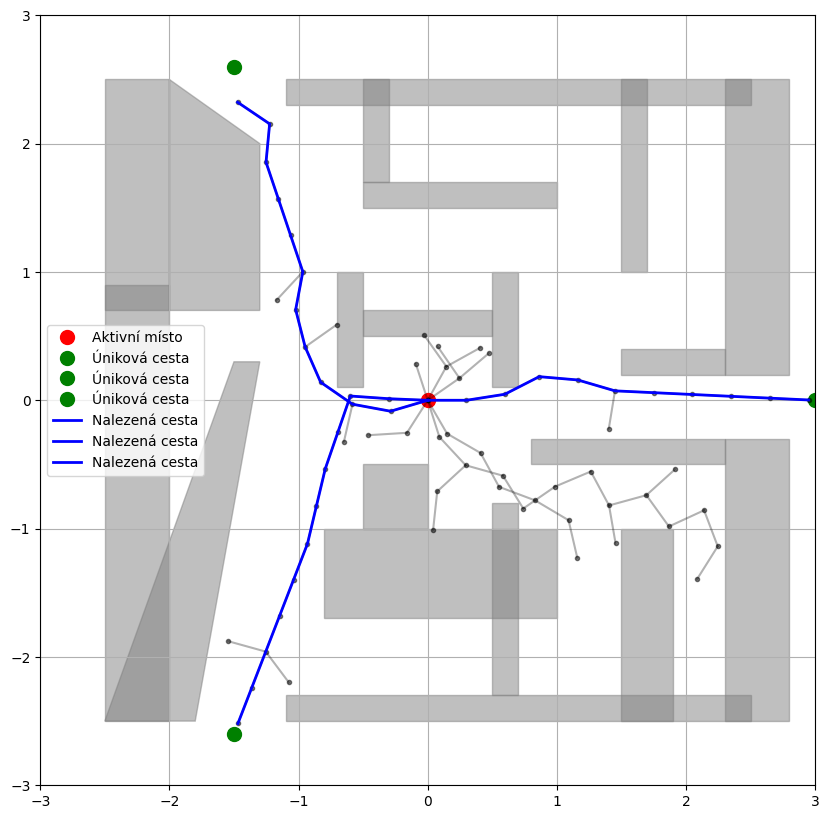

Běh 1: Detekováno 3 z 3 tunelů.


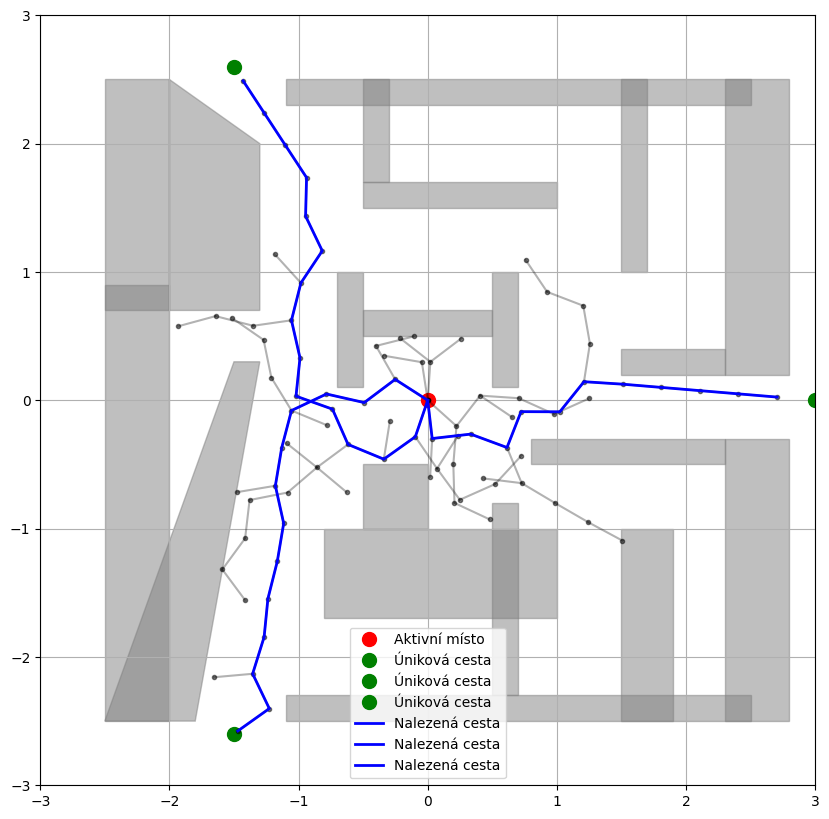

Běh 2: Detekováno 3 z 3 tunelů.


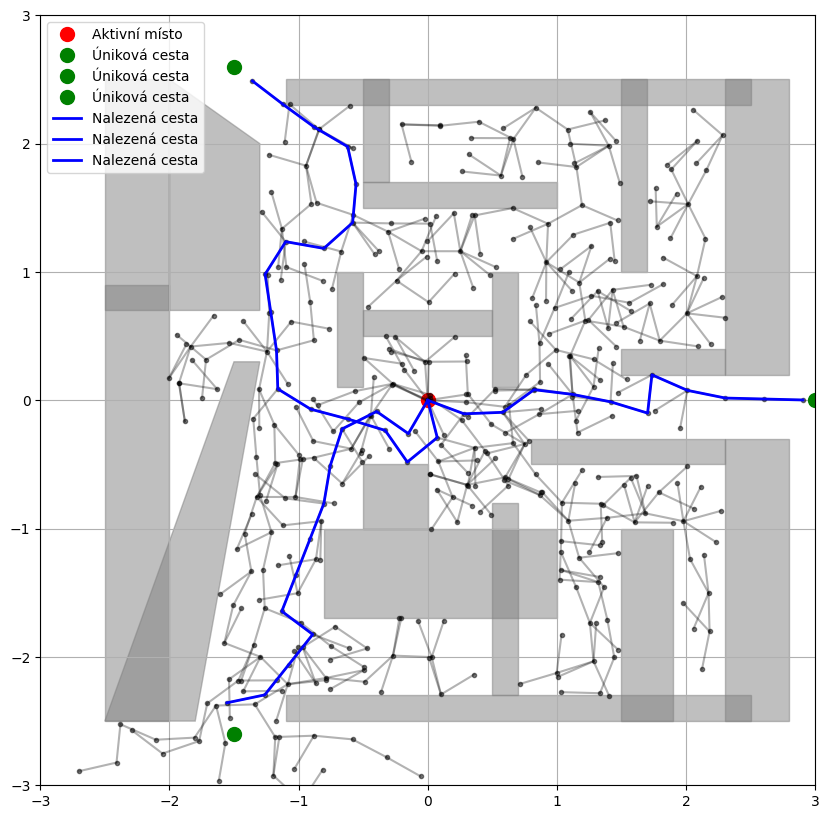

Běh 3: Detekováno 3 z 3 tunelů.


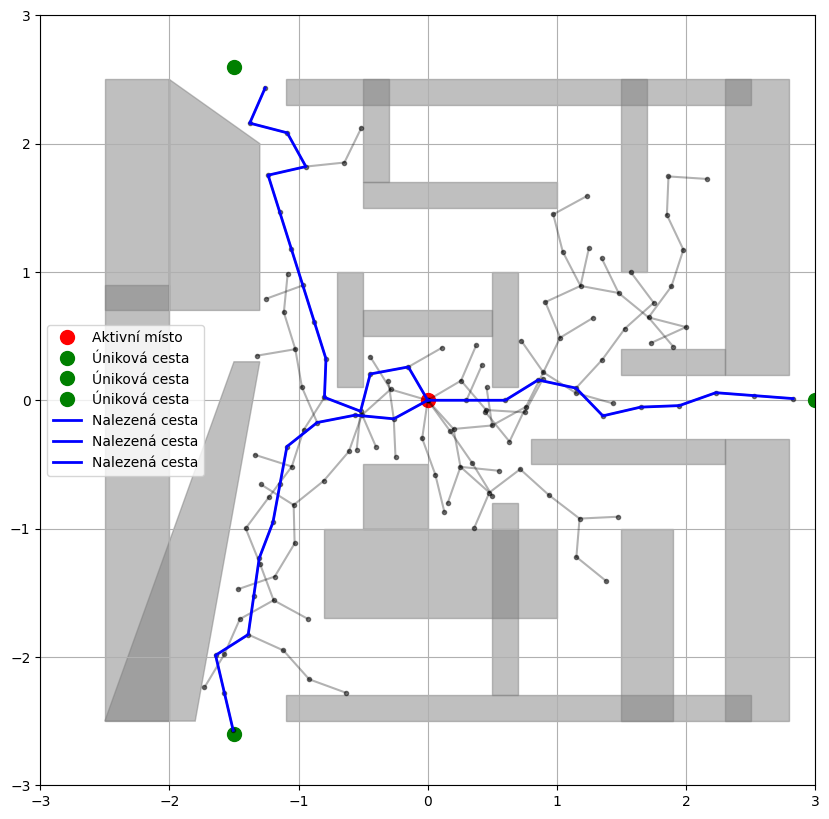

Běh 4: Detekováno 3 z 3 tunelů.


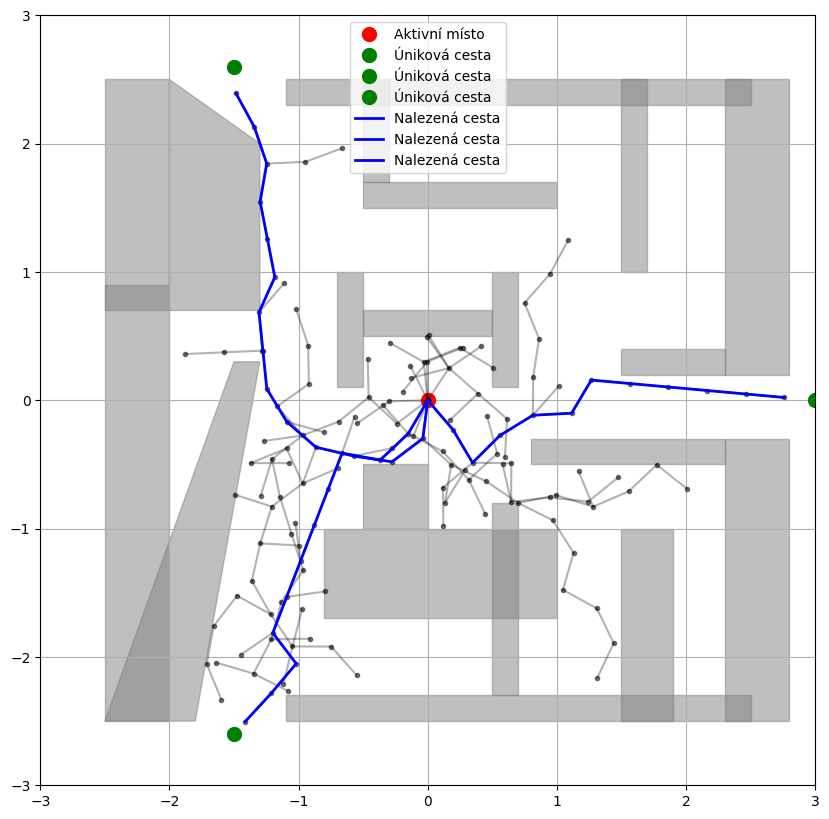

Běh 5: Detekováno 3 z 3 tunelů.


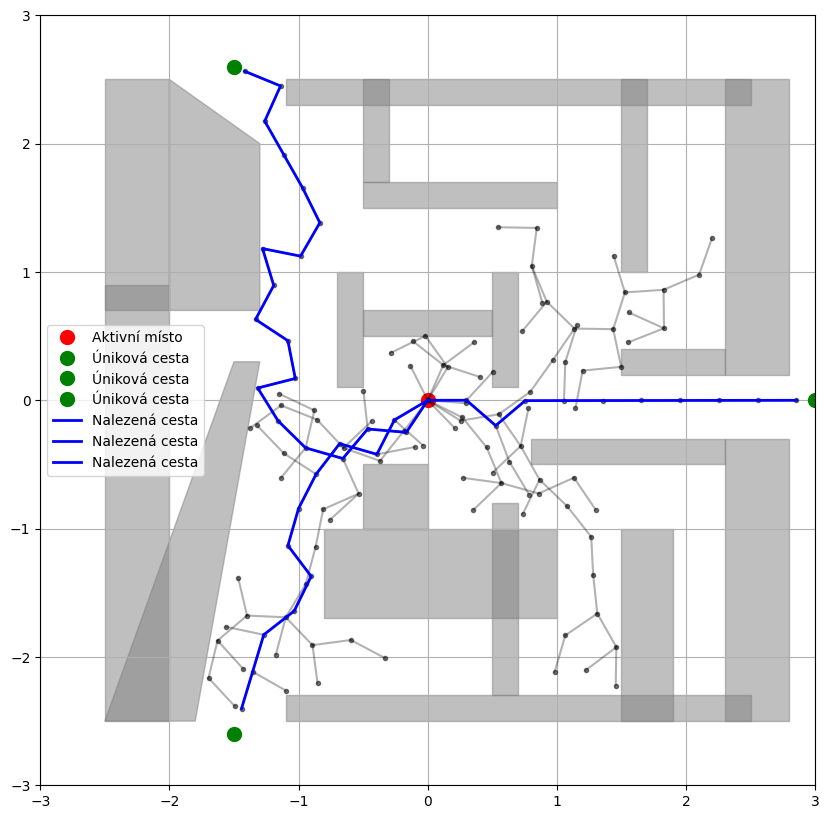

Běh 6: Detekováno 3 z 3 tunelů.


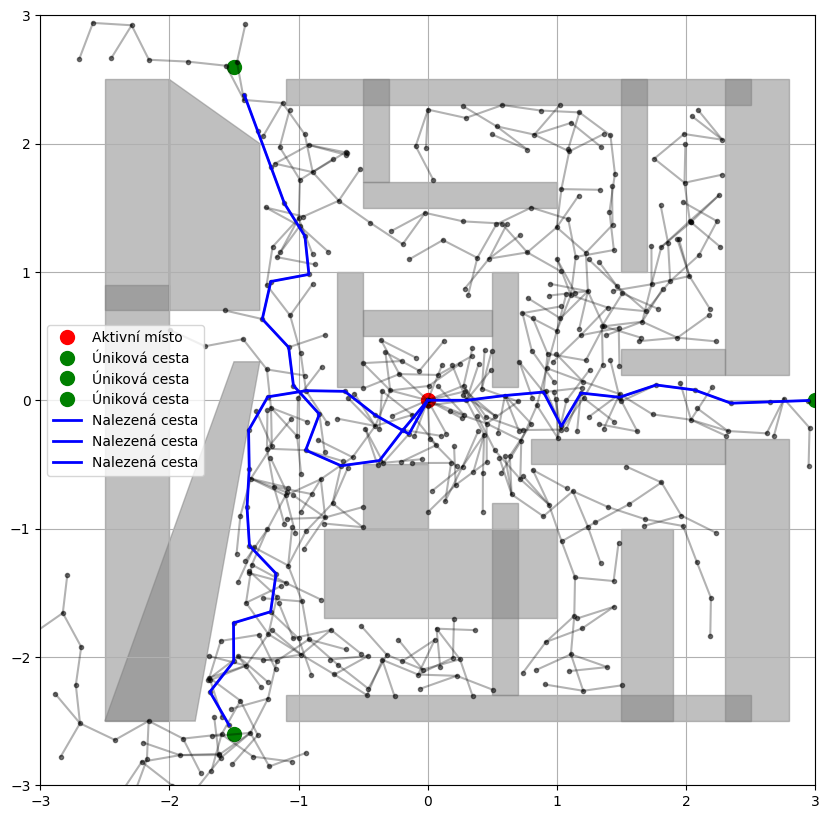

Běh 7: Detekováno 3 z 3 tunelů.


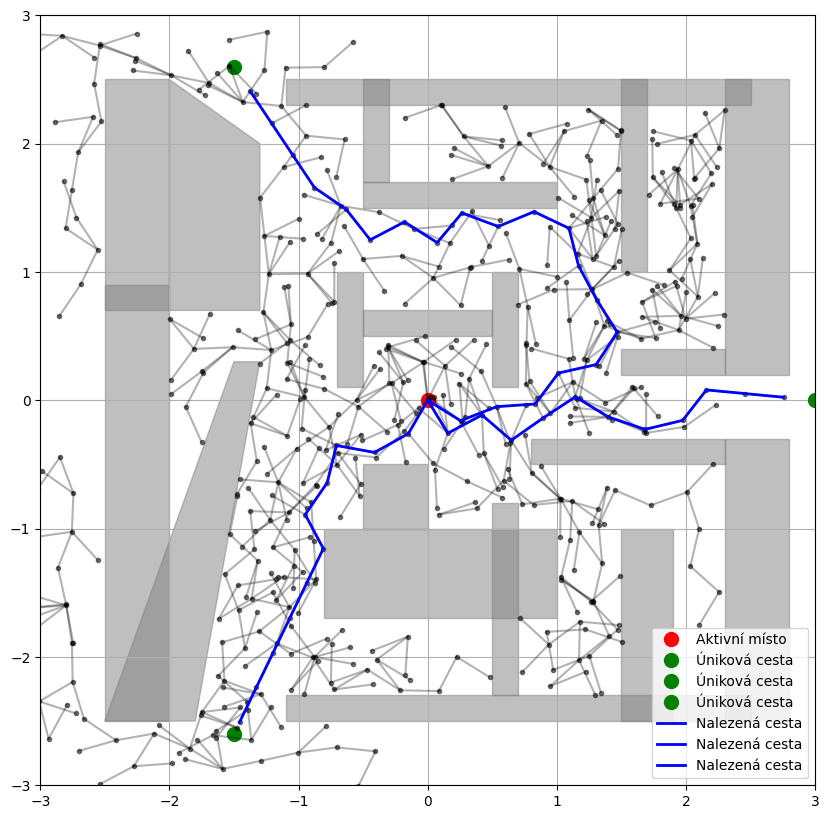

Běh 8: Detekováno 3 z 3 tunelů.


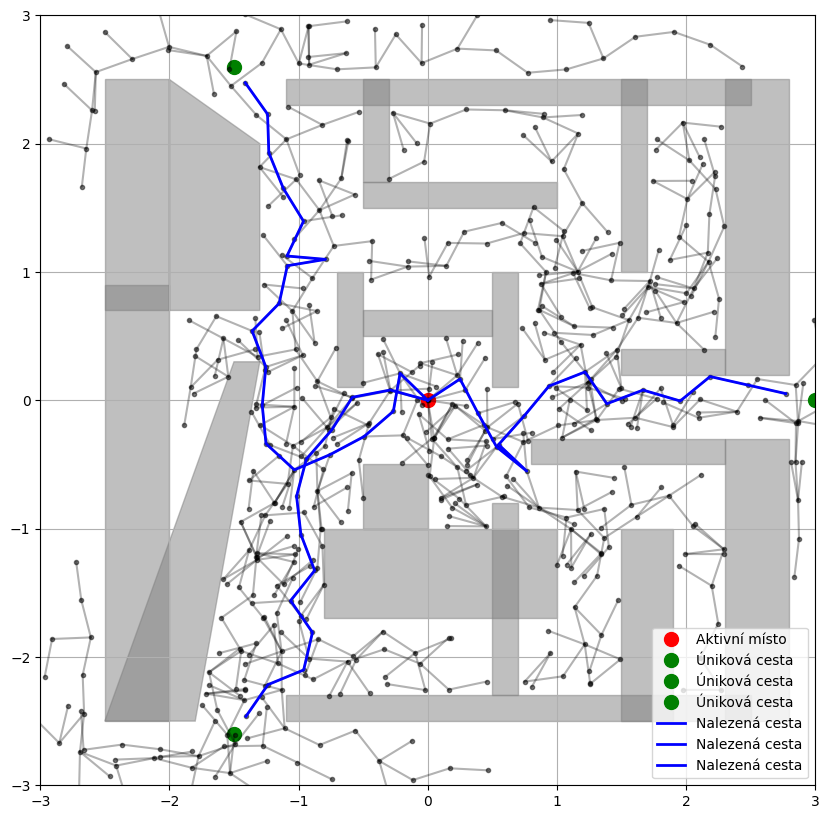

Běh 9: Detekováno 3 z 3 tunelů.


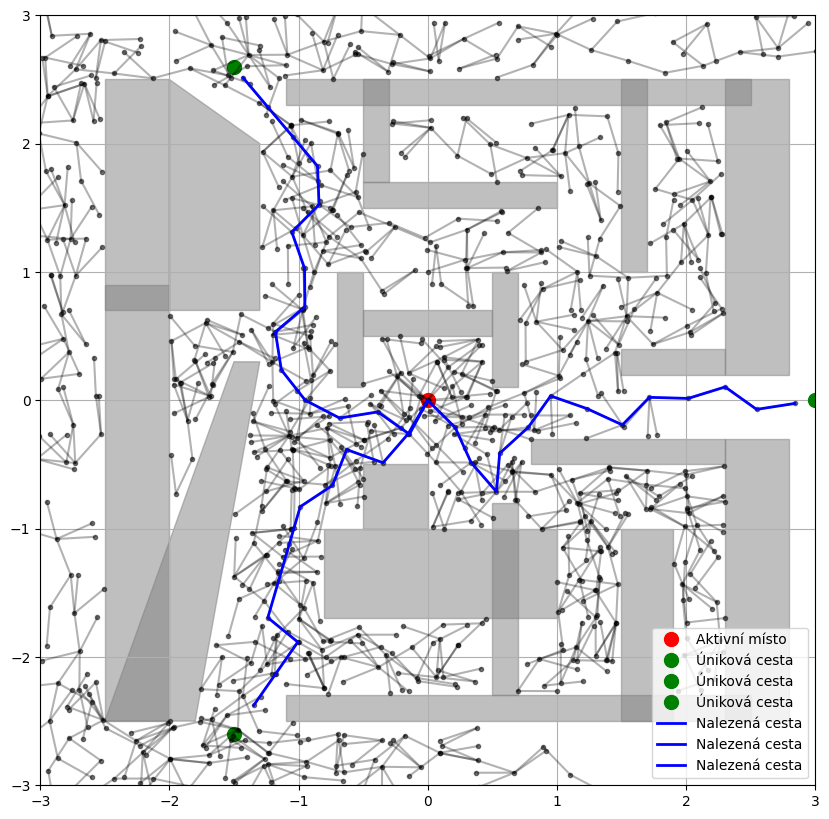

Běh 10: Detekováno 3 z 3 tunelů.


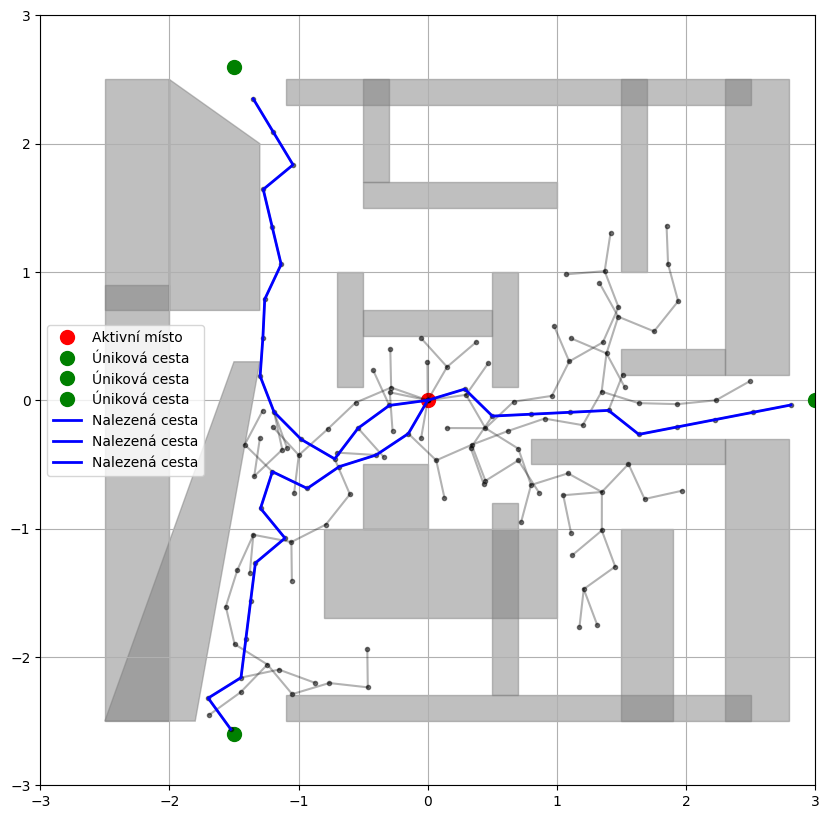

Běh 11: Detekováno 3 z 3 tunelů.


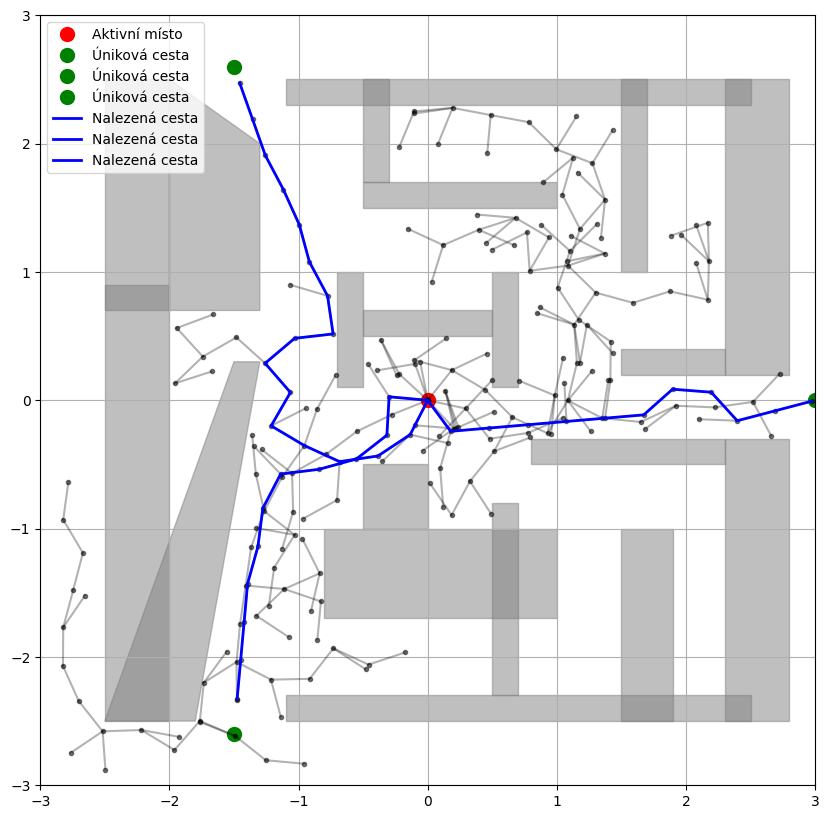

Běh 12: Detekováno 3 z 3 tunelů.


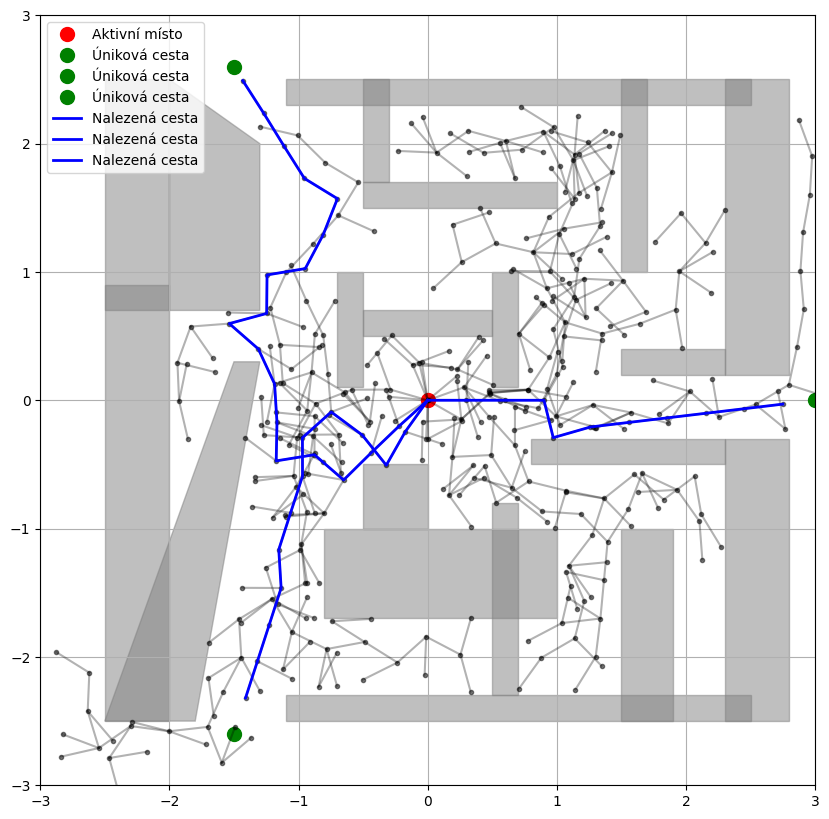

Běh 13: Detekováno 3 z 3 tunelů.


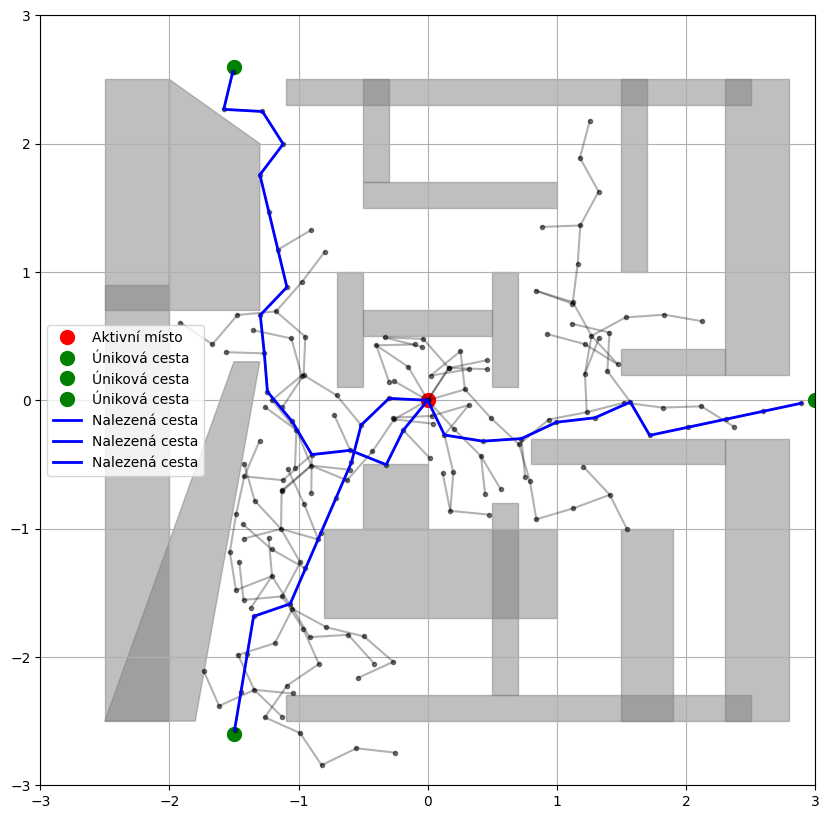

Běh 14: Detekováno 3 z 3 tunelů.


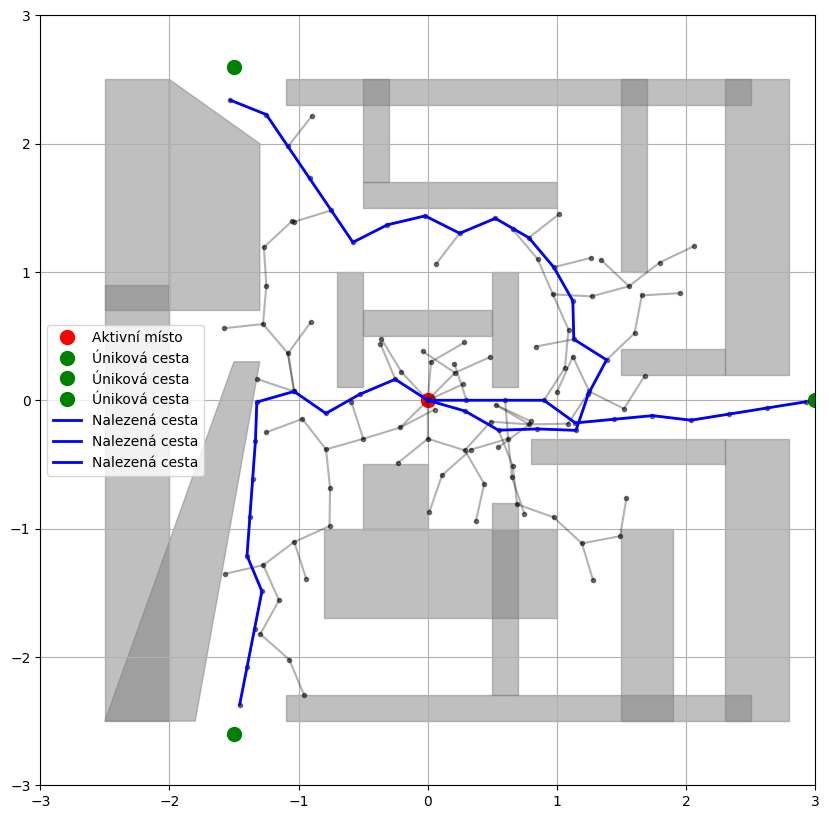

Běh 15: Detekováno 3 z 3 tunelů.


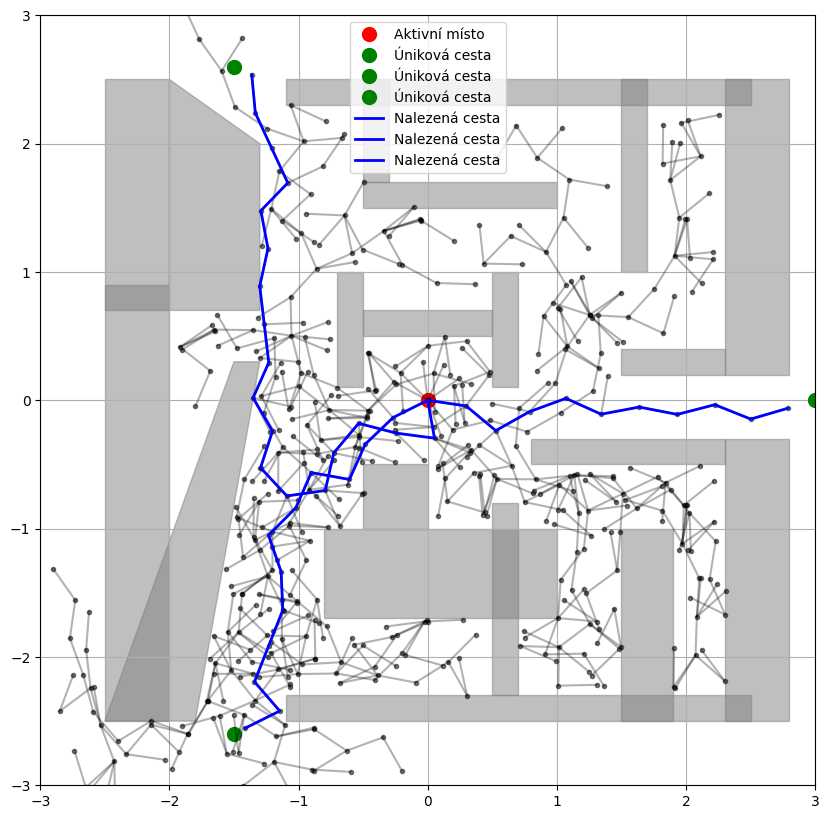

Běh 16: Detekováno 3 z 3 tunelů.


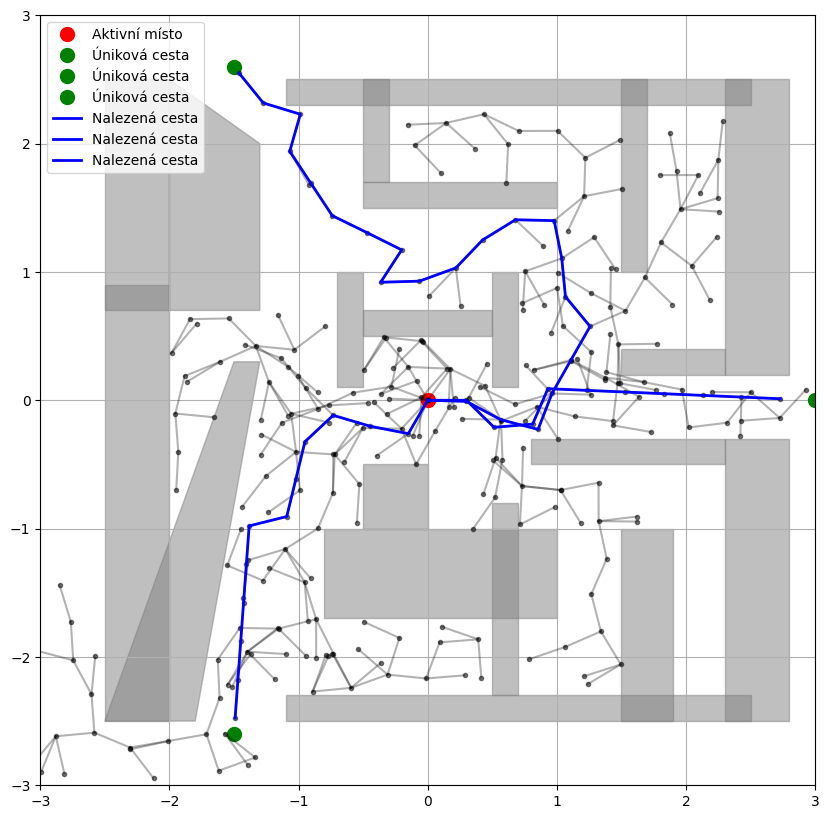

Běh 17: Detekováno 3 z 3 tunelů.


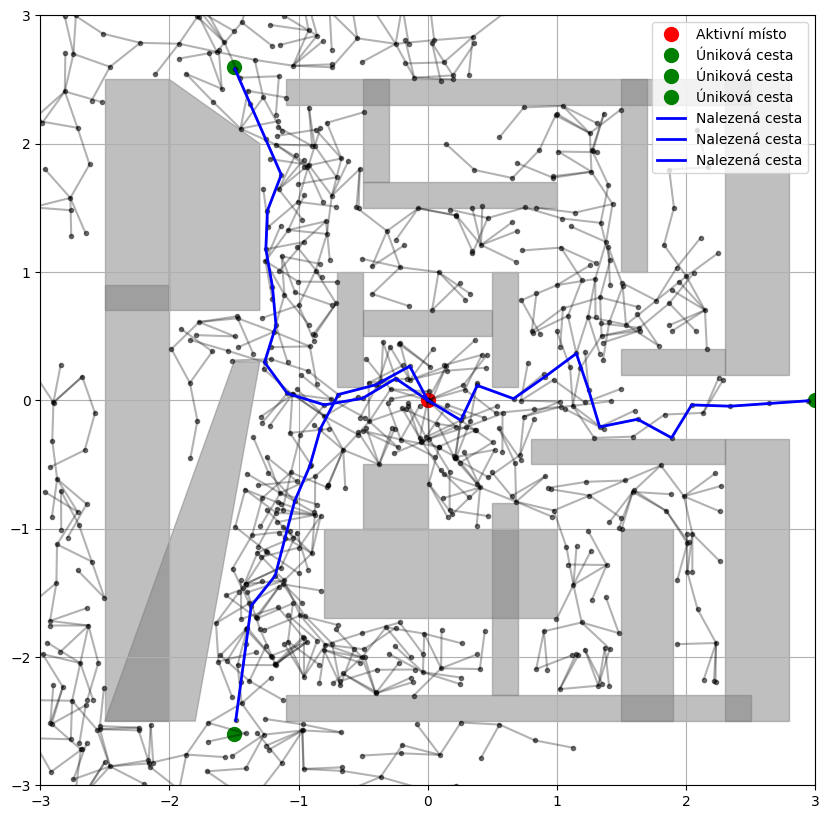

Běh 18: Detekováno 3 z 3 tunelů.


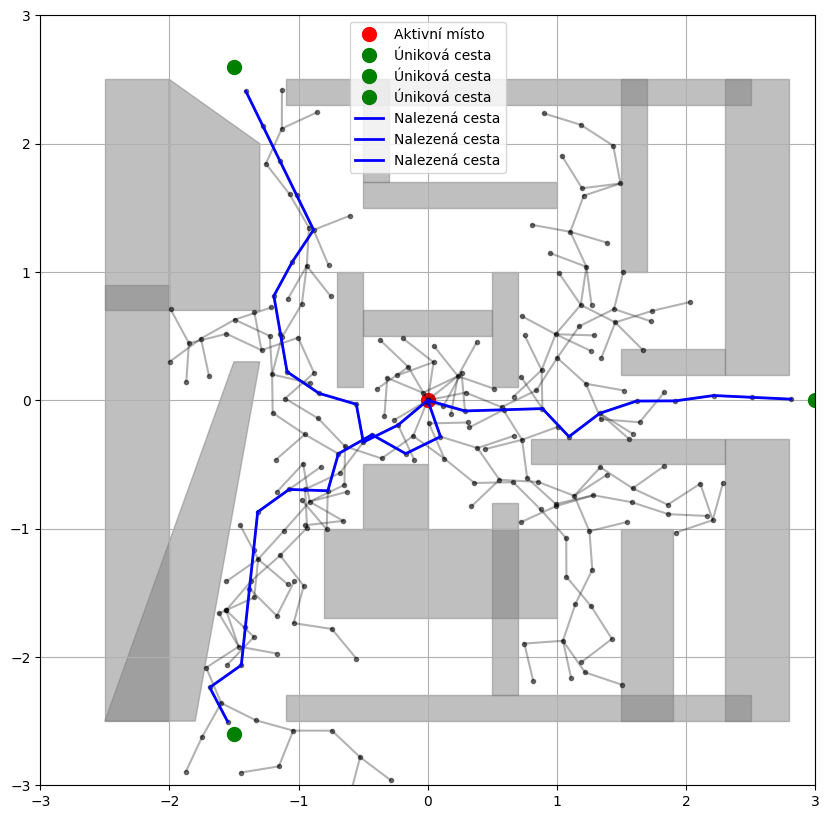

Běh 19: Detekováno 3 z 3 tunelů.


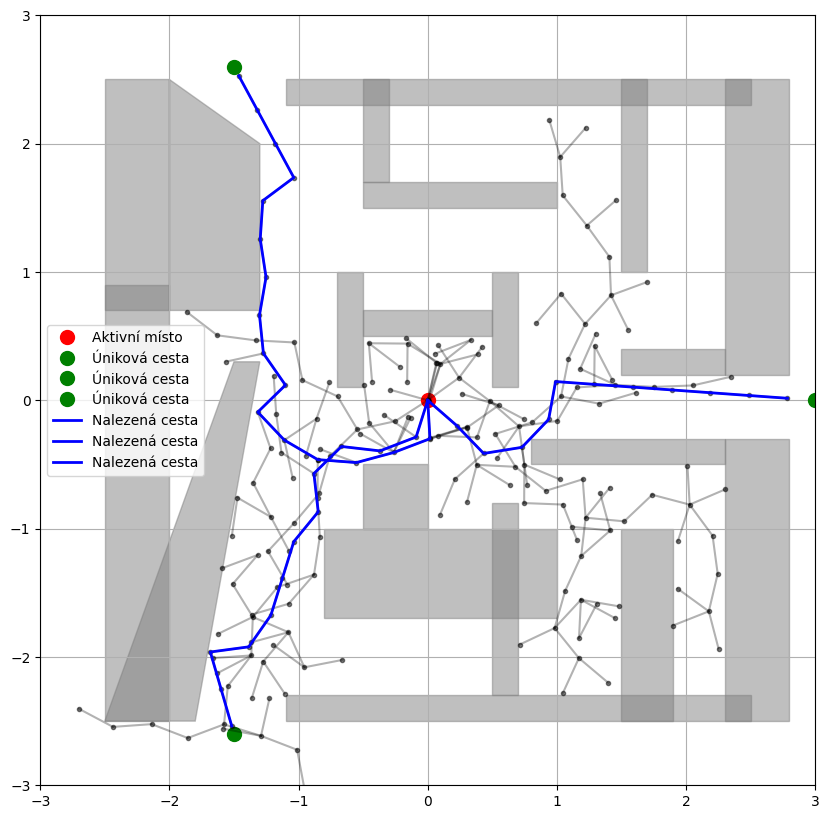

Běh 20: Detekováno 3 z 3 tunelů.
Z 20 běhů bylo všech 3 tunelů detekováno v 20 bězích.


In [3]:
# Třída reprezentující uzel v RRT
class Node:
    def __init__(self, position, index, prev_index):
        self.p = position
        self.i = index
        self.iPrev = prev_index

# Funkce pro nalezení nejbližšího uzlu

def closestNode(rrt, p):
    distances = [norm(np.array(p) - np.array(node.p)) for node in rrt]
    ind_min = np.argmin(distances)
    return rrt[ind_min]

# Funkce pro spuštění RRT

def run_rrt(obstacles, xy_start, xy_goal, maxiters=5000, minDistGoal=0.3, d=0.3):
    """
    Spouští algoritmus RRT pro nalezení cesty z počátečního bodu do cíle.
    """
    rrt = [Node(xy_start, 0, None)]
    for _ in range(maxiters):
        rnd = random()
        xy = xy_goal if rnd < 0.1 else np.array([random() * 6 - 3, random() * 6 - 3])
        if not isCollisionFreeVertex(obstacles, xy):
            continue
        closest_node = closestNode(rrt, xy)
        new_pos = closest_node.p + d * (xy - closest_node.p) / norm(xy - closest_node.p)
        if not isCollisionFreeEdge(obstacles, closest_node.p, new_pos):
            continue
        new_node = Node(new_pos, len(rrt), closest_node.i)
        rrt.append(new_node)
        if norm(np.array(xy_goal) - np.array(new_pos)) < minDistGoal:
            path = []
            current = new_node
            while current.i != 0:
                path.append(current.p)
                current = rrt[current.iPrev]
            path.append(xy_start)
            return np.array(path[::-1]), rrt
    return None, rrt

# Kontrola detekce všech tunelů

def check_tunnels_detected(paths, escape_routes):
    """
    Ověřuje, zda byly všechny únikové cesty dosaženy.
    """
    return len(paths) == len(escape_routes)


# Simulace více běhů
num_runs = 20
results = []
for run_index in range(num_runs):
    paths = []
    all_nodes = []

    # Vytvoříme nový graf pro každý běh
    plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])

    # Vykreslíme mapu (pouze jednou na začátku každého běhu)
    # draw_map(obstacles, active_site, escape_routes, [], [])
    for obstacle in obstacles:
        ax.add_patch(Polygon(obstacle, color='gray', alpha=0.5))
    if active_site is not None:
        plt.plot(active_site[0], active_site[1], 'ro', markersize=10, label='Aktivní místo')
    if escape_routes is not None:
        for route in escape_routes:
            plt.plot(route[0], route[1], 'go', markersize=10, label='Úniková cesta')

    for goal in escape_routes:
        path, rrt_nodes = run_rrt(obstacles, active_site, goal)
        if rrt_nodes:
            all_nodes = rrt_nodes  # Zobrazit pouze uzly aktuálního cíle
        if path is not None:
            paths.append(path)
            # Kreslení uzlů RRT do stejného grafu
            for node in rrt_nodes:
                if node.iPrev is not None:
                    prev_node = rrt_nodes[node.iPrev]
                    plt.plot([node.p[0], prev_node.p[0]], [node.p[1], prev_node.p[1]], 'k-', alpha=0.3)
                plt.plot(node.p[0], node.p[1], 'ko', markersize=3, alpha=0.5)

    # Vykreslení nalezených cest do stejného grafu
    if paths:
        for path in paths:
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, label='Nalezená cesta')

    # Vykreslení mapy s překážkami, únikovými cestami a nalezenými cestami
    plt.legend()
    plt.show()

    results.append(check_tunnels_detected(paths, escape_routes))
    print(f"Běh {run_index + 1}: Detekováno {len(paths)} z {len(escape_routes)} tunelů.")

print(f"Z {num_runs} běhů bylo všech {num_tunnels} tunelů detekováno v {sum(results)} bězích.")
